# Tutorial: Computation Graphs and TensorFlow

This is an introduction into the declarative programming paradigm used for computing by building a graph. The tutorial uses TensorFlow as an implementation.

**DISCLAIMER**: this tutorial does **not** demonstrate how to write **efficient** or even **good** code in TensorFlow. It only serves the purpose of getting to understand certain (general and TensorFlow specific) **concepts**!

## Imperative paradigm or just pure python

Before we go to the actual graphs, let's see what are non-graph computation.

Calculations in Python are straight forward, for example as done below. To give it a name, this is an imperative paradigm, it's what most programs do. It means "executing one line of code changes a value".

In [1]:
const_5 = 5
const_3 = 3
sum_5_3 = const_5 + const_3

const_7 = 7
const_2 = 2
sum_7_2 = const_7 + const_2

prod_sums = sum_5_3 * sum_7_2

We get an object out of the calculations:

In [2]:
prod_sums

72

Unfortunately, this was not really efficient and we cannot deduce any more information form the output about where the number comes from 

*(equivalent to solving a simple physics exercise algebraic versus directly inserting the numbers into every variable)*

## Declarative paradigm and Lazy evaluation

So it would be better, to "build" the calculation in the first place. Therefore, we need so-called "lazy evaluation", an object that first gets composed and run afterwards. This is a declarative programing style: we don't tell exactly what to do but rather what we wan't.



## Optional (for coders): Lazy evaluation in python

Let's do a very simple example of lazy evaluation (not really declarative actually) in python.

In [3]:
# Two equivalent ways of writing a function in python
def func():
    return 42
func = lambda: 42

In [4]:
const_5 = lambda: 5
const_3 = lambda: 3
sum_5_3 = lambda: const_5() + const_3()

const_7 = lambda: 7
const_2 = lambda: 2
sum_7_2 = lambda: const_7() + const_2()

prod_sums = lambda: sum_5_3() * sum_7_2()

And now we did not yet evaluate anything.

In [5]:
prod_sums

<function __main__.<lambda>()>

To evaluate this object, we simply call it:

In [6]:
prod_sums()

72

The advantage over the previous approach: we _could_ use the information stored in prod_sums to improve the calculation _before_ we run it.

In [7]:
import inspect
lines = inspect.getsource(prod_sums)
print(lines)

prod_sums = lambda: sum_5_3() * sum_7_2()



## Building a Graph

Let's now try to use the declarative paradigm and build a graph. The basic idea is that we don't tell what to _execute_ but just what we _want_. And in our case TensorFlow handles the rest

In [8]:
import tensorflow as tf

In [9]:
const_5 = tf.constant(5.)
const_3 = tf.constant(3.)
sum_5_3 = tf.add(const_5, const_3)

# or even simpler
const_7 = tf.constant(7.)
const_2 = tf.constant(2.)
sum_7_2 = tf.add(const_7, const_2)

prod_sums = tf.multiply(sum_5_3, sum_7_2)

In [10]:
prod_sums

<tf.Tensor 'Mul:0' shape=() dtype=float32>

Before we hat a function, that was our lazy evaluatable object, now it's a Tensor. Names don't matter here. This looks like the following: ![graph structure visualized](images/graph_structure_addition.png)

We **just** created the graph now, the instructions on what we **want** but we did not tell that we want the result now. The object we have is an instruction, not a number.

In [11]:
sess = tf.InteractiveSession()

In [12]:
prod_sums_number = sess.run(prod_sums)  # this command actually executes the instruction

In [13]:
prod_sums_number  # this is now a number

72.0

### Optional (for coders): did we really build a graph?
Yes! Nothing else. Let's explore the graph by walking through it.

In [14]:
prod_sums  # output from the operation...

<tf.Tensor 'Mul:0' shape=() dtype=float32>

In [15]:
prod_sums.op  # multiplies the inputs:

<tf.Operation 'Mul' type=Mul>

In [16]:
prod_sums.op.inputs[:]  # with for example input 0 from the op..

[<tf.Tensor 'Add:0' shape=() dtype=float32>,
 <tf.Tensor 'Add_1:0' shape=() dtype=float32>]

In [17]:
prod_sums.op.inputs[0].op  # the first add with inputs

<tf.Operation 'Add' type=Add>

In [18]:
prod_sums.op.inputs[0].op.inputs[:]

[<tf.Tensor 'Const:0' shape=() dtype=float32>,
 <tf.Tensor 'Const_1:0' shape=() dtype=float32>]

We have the whole definition at hand! It is a simple matter of implementations to, for example, check if a value depends on another (by recursively searching its inputs if it is there). Since TensorFlow also supports control flow operations, the whole process of building the graph is like building an AST (Abstract Syntax Tree) and therefore similar to writing compiler code.

## Automatic differentiation
A very useful thing we can get out is the gradient. Using the chain rule (but that's an unimportant implementation detail), TensorFlow is able to compute the derivative of **any** node with respect to **any** other node. 

Let's look at the example we had before
$$
prod\_sums(const\_5) = (const\_5 + const\_3) \cdot (const\_7 + const\_2)
$$

if we take the derivative with respect to $const\_5$

$$
\frac{\partial prod\_sums}{\partial const\_5} = const\_7 + const\_2 = 9
$$



In [19]:
derivate_sum_by_const5 = tf.gradients(prod_sums, const_5)[0]

In [20]:
derivate_sum_by_const5  # this is again a Tensor, an instruction how to do computation

<tf.Tensor 'gradients/Mul_grad/Mul:0' shape=() dtype=float32>

In [21]:
sess.run(derivate_sum_by_const5)  # as expected, this is 9

9.0

Sidenote: this is taking the derivative of prod_sums with respect to the _node_ const_5 and _then_ evaluates this by inserting 5 into the node const_5.

## Using variables

The above is not yet very useful, since we cannot change the values of a node. What we want is a more general structure that allows to define e.g. a model that can be changed with parameters.

In [22]:
const_2 = tf.constant(2.)
var_1 = tf.Variable(name="variable1", initial_value=3.)
sess.run(var_1.initializer)  # just a thing needed to do, not important

Instructions for updating:
Colocations handled automatically by placer.


In [23]:
# now create an operation as before
power_var1_const2 = tf.pow(var_1, const_2)  # this is basically just a square

In [24]:
sess.run(power_var1_const2)

9.0

In [25]:
# now let's change the value of the variable
var_1.load(4.)  # you can also enter your own number here

In [26]:
# we can now either rerun the cell above or create a new cell here and enter the same command again.
# For illustrative purpose the second is done here
sess.run(power_var1_const2)

16.0

Let's take the derivative with respect to the variable `var_1` (which is done equivalently as before).

$$
\frac{\partial power\_var1\_const2}{\partial var_1} = const\_2 \cdot var\_1 ^ {const\_2 - 1}
$$

For $var\_1 = 4$ (as we set above) we get 8.


In [27]:
deriv_power_var = tf.gradients(power_var1_const2, var_1)

In [28]:
sess.run(deriv_power_var)  # as predicted

[8.0]

## Fitting a line
Let's try to do a simple straight line fit. First we create some data in the next cell. If you're not familiar with Python and numpy, you can also skip this part. The important thing is: we create data along a straight line with a (random) slope. The actual slope is saved in `true_slope`.

In [29]:
# generating some data
n_events = 300
true_slope = np.random.uniform(low=0.3, high=3)  # generate randomly a slope 
x_data = np.random.uniform(low=-10, high=10, size=n_events)  # generate points between -100 and 100
y_clean = true_slope * x_data           # this is the function y = slope * x
y_data = y_clean + np.random.normal(loc=0, scale=1.5, size=n_events)  # just adding some random noise

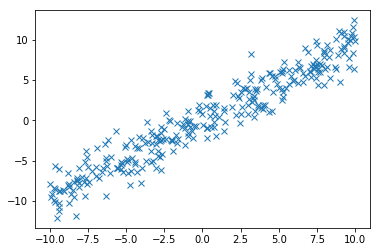

In [30]:
# to visualize the data
plt.plot(x_data, y_data, 'x')

### Making an ansatz

Let's make an ansatz with a straight line.
$$
f(x) = y = slope \cdot x
$$

Technically, we know several x and y from the data (fixed) and want to change slope so that the y is as close as possible to the y_data. 

In [31]:
# create the variable to be changed
slope = tf.Variable(name="slope", initial_value=1.)
sess.run(slope.initializer)  # ignore line basically

y = slope * x_data

### Defining a loss

We need to specify what it means that "y_data should be as close as possible to y". This is called the loss, which tells how "bad" the function is. As an example, we can take the squared distance of y and y_data.

$$
y_{dist} = y_{data} - f(x_{data}; slope)
$$
this is the differnce between the data and the prediction from our ansatz.

$$
squared\_dist\_loss = \sum_i y_{dist\ i}^2
$$

The goal is to minimize this expression.

In [32]:
# create a loss
squared_dist_loss = tf.reduce_sum(tf.square(y - y_data))

# since it can be useful, let's also create the instructions on how to compute the gradient
grad_loss_wrt_slope = tf.gradients(squared_dist_loss, slope)[0]  # taking element 0 since it returns a list, not a scalar

## Playground minimization

Now we got everything: the instruction (operation) on how to compute the square distance loss (`squared_dist_loss`) and the parameter (`slope`) that parametrizes our ansatz. Use the two (three) cells below to minimize the loss and find the true slope.

***Exercise***: call the loss cell, then load a different value, see how that changes the loss by running the first cell again and repeat until you find the minimum of it. Hint: if you finished and want to run the whole minimization for a new dataset and a new `true_slope`, restart the notebook and run everything again. Otherwise go for the optional advanced automatic minimization.

In [33]:
sess.run(squared_dist_loss)

807.6632

In [34]:
slope.load(1.5)  # change between [0.3, 3]

#### Using the gradient
Being smart, we can use the gradient information as well. Since it point into the direction of the steepest **ascent**, using the negative of it points into the direction of the **descent**. This tells us in which direction to change the parameter.

$$
grad\_loss\_wrt\_slope = \frac{\partial squared\_dist\_loss}{\partial slope}
$$

In [35]:
sess.run(grad_loss_wrt_slope)

11606.9795

In [36]:
# uncomment the below to see the true value
# true_slope

### Optional (advanced): automatize the minimization

Why not create a while loop and automatize this? If you feel comfortable enough with the above and python, implement a loop. Hint: a criteria to stop the loop (convergence criteria) could be the absolute value of the gradient being smaller than a certain stopping value. And don't make too big steps, rather too small ones.

In [37]:
# do your minimization here

## Changing our goal

We created a simple loss using the sum of the squared distances. However, we can create way more sophisticated losses by adding more terms to it. For example if we do know that the slope is close to 1 (e.g. from other measurements), we can add an additional term that penalizes if `slope` is not close to 1.

*(30'000 is just to increase the effect and make it visible)*
$$
slope_{constr} = (slope - slope_{assumed}) ^ 2 \cdot 20'000
$$

*(In physics and fitting, this is usually called "adding a constraint to a parameter")*

In [38]:
slope_assumed = tf.constant(1.)  # any number within the boundaries [0.3, 3]
slope_constr = tf.square(tf.subtract(slope, slope_assumed)) * 20000
squared_dist_constr = squared_dist_loss + slope_constr

We minimized by hand before (and it was cumbersome) but there are already pre-built minimizers (and in practice, we gonna **always** use them). So let's try one. There are a few different ones and some converge better for certain problems then others. In general, `Adam` performs overall very well.

In [39]:
# here we create an instance of the optimizer, this needs to be done once
optimizer = tf.train.AdamOptimizer(learning_rate=3.)

In [40]:
minimize_op = optimizer.minimize(squared_dist_constr)  # as before, this is also just an operation!
sess.run(tf.variables_initializer(optimizer.variables()))  # just a necessity, not important

Now we can run the optimization. `minimize_op` just performs one step of the optimization (one step along the negative gradient) so we do it a couple of times (e.g. 1'000). Of course, a while loop with a good convergence criteria would be more suited in general.

In [41]:
# execute the minimization operation here
for _ in range(1000):
    sess.run(minimize_op)  # this is only one minimization step

In [42]:
# to check the value of the slope, we also need to run it
sess.run(slope)

0.9809439

In [43]:
# uncomment to see the true slope. This will NOT coincide with our slope and should be closer to 1
# since we added the constraint
true_slope

0.9428728819652632

## Optional: optimizer on the previous loss

We can also minimize the original squared distance loss with an optimizer.

In [44]:
minimize_op_squared_dist = optimizer.minimize(squared_dist_loss)  # as before, this is also just an operation!
sess.run(tf.variables_initializer(optimizer.variables()))  # just a necessity, not important

In [45]:
# execute the minimization operation here
for _ in range(1000):
    sess.run(minimize_op_squared_dist)  # this is only one minimization step

In [46]:
sess.run(slope)

0.9444609

In [47]:
true_slope

0.9428728819652632